# Importing PDF

### Brief note:
1. There has 536 pdfs, and 350 of them are extractable pdf files.
2. Text cleaning has been applied to raw texts, both raw data and cleaned data are saved as pickle files, doc.pkl and corpus.pkl respectively.
3. It will take 15~20 mins to run 

### Packages 

In [17]:
# In case you don't have these packages, uncomment code to install them

#!pip install pdfminer.six

#!pip install PyPDF2

#!pip install PyMuPDF

In [2]:
import os
import PyPDF2
import fitz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import pickle
import spacy

### File Path settings

In [46]:
# change to your directory
FILE_PATH = '../NSV/nsv_pdfs/'

In [48]:
file_list = [f for f in os.listdir(path=FILE_PATH) if f.endswith('.pdf') or f.endswith('.PDF')]

In [49]:
print(file_list[0:5])

['FullReport.pdf', 'USSS_NTAC-Mass_Attacks_in_Public_Spaces-2017_0.pdf', 'Morrison_Autopsy.pdf', 'Alex_Hribal_criminal_complaint.pdf', 'Ohio_v_Halder_Supreme_Court.pdf']


In [50]:
# See how many files are included
print(len(file_list))

536


In [52]:
file_not_show = [f for f in os.listdir(path=FILE_PATH) if f not in file_list]
file_not_show

['.DS_Store', 'database_subjects_10.xlsx']

### Find scanned pdfs

*The algorithm I used in here reference from https://stackoverflow.com/questions/55704218/how-to-check-if-pdf-is-scanned-image-or-contains-text*
* It is not able to find text/image mixed pdfs, so futher analysis will applied in extraction procedure
* If the pdf is scanned type, the score will equal to 1.

In [24]:
def get_text_percentage(file_name):
    """
    Calculate the percentage of document that is covered by (searchable) text.

    If the returned percentage of text is very low, the document is
    most likely a scanned PDF
    """
    total_page_area = 0.0
    total_text_area = 0.0
    # file path
    try:
        path = FILE_PATH+file_name
        doc = fitz.open(path)

        for page_num, page in enumerate(doc):
            total_page_area = total_page_area + abs(page.rect)
            text_area = 0.0
            for b in page.getTextBlocks():
                r = fitz.Rect(b[:4])  # rectangle where block text appears
                text_area = text_area + abs(r)
            total_text_area = total_page_area + text_area
        doc.close()
        return total_text_area / total_page_area
    except:
        return 0


In [25]:
# calculate scanned pdf scores for each file
searchable_scores = {filename:[get_text_percentage(filename)] for filename in file_list}    

mupdf: No default Layer config
mupdf: unknown keyword: 'QBX'
mupdf: No default Layer config
mupdf: cmsOpenProfileFromMem failed
mupdf: expected object number
mupdf: invalid page object


In [26]:
# create a datafame for the result
scores_df = pd.DataFrame.from_dict(searchable_scores).transpose()
scores_df.columns = ['scores']

In [27]:
# check if each pdf got its scores
len(scores_df)

536

In [28]:
scores_df[scores_df.scores==1]

,scores
Morrison_Autopsy.pdf,1.0
Alex_Hribal_criminal_complaint.pdf,1.0
Enhancing_School_Safety.pdf,1.0
FBI_Sandy_Hook_Part_3.pdf,1.0
Spencer_Parole_Hearing_1994.pdf,1.0
...,...
Nikolas_Cruz_Interview_Transcript.pdf,1.0
Hancock_note.pdf,1.0
Report-involving-TJ-Lane.pdf,1.0
"JCSO Pages 8,001 - 9,000.pdf",1.0


In [29]:
# create a list for scanned pdfs
scanned_pdfs = scores_df[scores_df.scores==1].index.tolist()

In [30]:
file_list = [file for file in file_list if file not in scanned_pdfs]

In [31]:
# check length of searchable pdfs
len(file_list)

363

### PDF extraction

In [4]:
# some helper function
def combine_texts(list_of_text):
    '''Taking a list of texts and combining them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

In [33]:
def combine_int(list_of_int):
    '''Taking a list of nnumbers and combining them into one large chunk of text.'''
    combined_text = ','.join(list_of_int)
    return combined_text

In [34]:
# PDF extraction
# imformations we want to extract
extraction_pdfs = {}

for file_name in file_list:
    #save the results
    unreadable_pages = []
    list_of_text = []
    buff_dict = {}
    # file path 
    path = FILE_PATH+file_name
    # create pdf reader object
    with open(path, 'rb') as pdfFileObj:
        
        # file reader
        try:
            pdfReader = PyPDF2.PdfFileReader(pdfFileObj,strict=False)
            # number of pages
            pages = pdfReader.numPages
            buff_dict['encrpyted'] = False
            buff_dict['pages'] = pages
            # loop over all pages and extract text, if not extractable, the page number will be recored    
            for page in range(pages):
                pageObj = pdfReader.getPage(page)
                try:
                    text_per_page = pageObj.extractText()
                    list_of_text.append(text_per_page)
                except:
                    unreadable_pages.append(page)
                    continue
            # adding unextractable page numbers into dictionary
            buff_dict['unextractable_pages'] = unreadable_pages
    
            # combine texts of each pages into a whole texts or called doc
            buff_dict['docs'] = combine_texts(list_of_text)
        except:
            buff_dict['encrpyted'] = True
            extraction_pdfs[file_name]=buff_dict
            continue
        
    extraction_pdfs[file_name]=buff_dict

In [35]:
# see encrypt pdfs
for k, v in extraction_pdfs.items():
    if v['encrpyted'] == True:
        print(k)

Spencer_Parole_Hearing_2009.pdf
Spencer_Parole_Hearing_2005.pdf
School_safety_report.pdf


In [36]:
# transfer unreadable_pages list into a string list in order to create dataframes
for k, v in extraction_pdfs.items():
    if v['encrpyted'] == False:
        str_list = [str(page) for page in v['unextractable_pages']]
        v['unextractable_pages'] = combine_texts(str_list)

In [37]:
extraction_pdfs['ssi_final_report.pdf']

{'encrpyted': False,
 'pages': 63,
 'unextractable_pages': '10 22 26 38 48 52',
 'docs': 'THE FINAL REPORT ANDFINDINGS OF THESAFE SCHOOLINITIATIVE:IMPLICATIONS FORTHE PREVENTION OFSCHOOL ATTACKS INTHE UNITED STATESUNITED STATES SECRET SERVICE ANDUNITED STATES DEPARTMENT OF EDUCATIONWASHINGTON, D. C.May 2002 iTHE FINAL REPORT AND FINDINGSOF THE SAFE SCHOOL INITIATIVE:IMPLICATIONS FOR THE PREVENTION OFSCHOOL ATTACKS  IN THE UNITED STATESUNITED STATES SECRET SERVICEANDUNITED STATES DEPARTMENT OF EDUCATIONbyBryan VossekuilDirectorNational Violence Prevention and Study CenterRobert A. Fein, Ph.D.DirectorNational Violence Prevention and Study CenterMarisa Reddy, Ph.D.Chief Research Psychologist and Research CoordinatorNational Threat Assessment CenterU.S. Secret ServiceRandy Borum, Psy.D.Associate ProfessorUniversity of South FloridaWilliam ModzeleskiDirectorSafe and Drug-Free Schools ProgramU.S. Department of EducationWashington, D. C.May 2002 JOINT MESSAGE FROM THE SECRETARY, U.S. DEPARTME

In [38]:
#extraction_pdfs['Odighizuwa_v_Ray_2006.pdf']

In [39]:
extraction_df = pd.DataFrame.from_dict({k:[v['pages'],v['unextractable_pages'],v['docs']] for k, v in extraction_pdfs.items() if v['encrpyted'] == False}).transpose()
extraction_df.columns = ['pages','unextractable_pages','docs']
extraction_df.head()

,pages,unextractable_pages,docs
FullReport.pdf,260,,"Mass Shootings at Virginia TechApril 16, 2007..."
USSS_NTAC-Mass_Attacks_in_Public_Spaces-2017_0.pdf,7,,D\nEPARTMENT OF \nH\nOMELAND \nS\nECURITY \n \...
Ohio_v_Halder_Supreme_Court.pdf,47,,"IN THE SUPREME COURT OF OHIO, . .STATE OF OHIO..."
Jaylen_Fryberg_second_documents.pdf,249,,"MPX00001 it. ""'Theaa detalls are cros:s.-refcm..."
atchison_online_1.0.pdf,61,,"WWW.SCHOOLSHOOTERS.INFO\n Peter Langman, Ph.D...."


In [40]:
# giving files that dont have unreadable pages a code '-1'
extraction_df.unextractable_pages.replace('','-1',inplace=True)

In [41]:
# see if there is file contains with unreadable pages
extraction_df[extraction_df.unextractable_pages!='-1']

,pages,unextractable_pages,docs
ssi_final_report.pdf,63,10 22 26 38 48 52,THE FINAL REPORT ANDFINDINGS OF THESAFE SCHOOL...
Campus_Safety_at_Oregon_IHEs.pdf,39,1 7,\n \n \n \n \nCampus Safety at Oregon \n \nPo...
Dunblane inquiry transcript.pdf,3376,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,
ssi_guide.pdf,99,10 18 24 36 50 70 76 84 88,THREAT ASSESSMENTIN SCHOOLS:A GUIDE TO MANAGIN...
Stephen Abbott Court Case.pdf,49,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,


In [42]:
# create a new column to see word count
extraction_df['words_count'] = extraction_df.docs.apply(len)

In [43]:
print('Average words of all pdfs:{:.0f}'.format(np.average(extraction_df.words_count)))
print("Max value:{}".format(np.max(extraction_df.words_count)))

Average words of all pdfs:131141
Max value:3058263


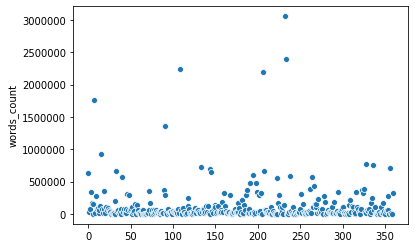

In [44]:
sns.scatterplot(x= range(len(extraction_df)),y='words_count',data=extraction_df)

(0, 10000)

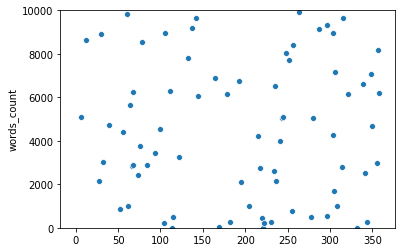

In [45]:
# see words_count in each pdfs 
sns.scatterplot(x= range(len(extraction_df)),y='words_count',data=extraction_df)
plt.ylim(0, 10000)

**Note:**\
Since average word count is 130k, some files seems to have anormal word counts especially those less than 1000 words. So we are going to take a look on those files

In [46]:
extraction_df[extraction_df.words_count <1000]

,pages,unextractable_pages,docs,words_count
ybarra_family_tree_1.0.pdf,1,-1,Aaron Ybarra: Family Tree\nCompiled by Peter L...,846
Fabrikant_2009_homepage.pdf,1,-1,WELCOME! I have compiled in this web site 3 ki...,983
stair_journal.pdf,237,-1,...,236
Hribal_Letter.pdf,4,-1,,11
Reyes_letters.pdf,2,-1,Police DepartmentControlled Document - Do Not ...,514
CSSRC-Essentials-of-TA-2018.pdf,27,-1,,26
book_9.pdf,261,-1,...,260
Romano_letter_after_attack.pdf,2,-1,"\n 194\n835\n:1˙!""I=<\n\nˇ˝ˆ$(˝\n\n\n*˛""3˝˛4...",981
Recommendations_for_Reporting_on_Mass_Shootings.pdf,2,-1,QšﬁÊÄÄšÅŽƒâ¯ÊÅÜYÊÖWY¬¯Å¨ÜhšhƒÅânÊåâÊ7ÅÊå™Êåââ¬...,451
Dunblane inquiry transcript.pdf,3376,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,,0


In [68]:
extraction_df[extraction_df.words_count > 1000]

,pages,unextractable_pages,docs,words_count
FullReport.pdf,260,-1,"Mass Shootings at Virginia TechApril 16, 2007...",626530
USSS_NTAC-Mass_Attacks_in_Public_Spaces-2017_0.pdf,7,-1,D\nEPARTMENT OF \nH\nOMELAND \nS\nECURITY \n \...,27594
Ohio_v_Halder_Supreme_Court.pdf,47,-1,"IN THE SUPREME COURT OF OHIO, . .STATE OF OHIO...",81287
Jaylen_Fryberg_second_documents.pdf,249,-1,"MPX00001 it. ""'Theaa detalls are cros:s.-refcm...",331546
atchison_online_1.0.pdf,61,-1,"WWW.SCHOOLSHOOTERS.INFO\n Peter Langman, Ph.D....",161827
...,...,...,...,...
Myron_May_police_report.pdf,2,-1,Crime/Incident ReportLCPDPrint Date: 11/20/20...,2989
Northern Illinois University Official Report.pdf,322,-1,"Report of the February 14, 2008 Shootings\nat ...",716543
bullying_school_shootings_1.2_0.pdf,3,-1,WWW.SCHOOLSHOOTERS.INFO\n Copyright \n© 2014 b...,8180
FERPA_K12.pdf,2,-1,"Transfer of Education Records\nFinally, under ...",6219


**Note:**\
some files have similar words_count and pages, when I checked those files, those are scanned type pdfs.

In [47]:
extraction_df[extraction_df['words_count']+1==extraction_df['pages']]

,pages,unextractable_pages,docs,words_count
stair_journal.pdf,237,-1,...,236
CSSRC-Essentials-of-TA-2018.pdf,27,-1,,26
book_9.pdf,261,-1,...,260
Flores_divorce_documents.pdf,226,-1,...,225
Pima_Community_College_emails.pdf,255,-1,...,254


### Including all unextractable pdfs

**Three type of pdfs are concluded:**
1. All scanned images
2. Encrypt files
3. Text/image mixed files

In [48]:
# All scanned images
file_names = extraction_df[extraction_df['words_count']+1==extraction_df['pages']].index.values
for v in file_names:
    scanned_pdfs.append(v)


In [49]:
# Encrypt files
encrypt_pdfs = []
# see encrypt pdfs
for k, v in extraction_pdfs.items():
    if v['encrpyted'] == True:
        encrypt_pdfs.append(k)

In [50]:
# Text/image mixed files
file_names = extraction_df[extraction_df.unextractable_pages!='-1'].index.values
mixed_pdfs = [f for f in file_names]

In [51]:
# dict contains all
unextractable_pdfs={'scan':scanned_pdfs,'encrypt':encrypt_pdfs,'mix':mixed_pdfs}

In [52]:
print('scanned_pdfs:{}'.format(len(unextractable_pdfs['scan'])))
print('encrypt_pdfs:{}'.format(len(unextractable_pdfs['encrypt'])))
print('mixed_pdfs:{}'.format(len(unextractable_pdfs['mix'])))

scanned_pdfs:178
encrypt_pdfs:3
mixed_pdfs:5


In [53]:
abnormal_pdfs = unextractable_pdfs['scan']+unextractable_pdfs['encrypt']+unextractable_pdfs['mix']

### Extract texts into Dataframe

In [54]:
file_list = [file for file in file_list if file not in abnormal_pdfs] 

In [55]:
# creating dataframe
dict_combined = {file:[extraction_df.loc[file,'docs'],extraction_df.loc[file,'pages']] for file in file_list}

In [56]:
data_df = pd.DataFrame.from_dict(dict_combined).transpose()
data_df.columns = ['docs','pages']
data_df = data_df.sort_index()
data_df

,docs,pages
11000_pg_report_part_1.pdf,"11,000 PAGE REPORT\n0001-0100Library Injured (...",14
11000_pg_report_part_2.pdf,"11,000 PAGE REPORT\npgs.5501-5600 to 10901-109...",17
2014-NaBITA-Whitepaper-Text-with-Graphics.pdf,THREAT \nASSESSMENT IN THE \nCAMPUS \nSETTIN...,28
ACSO_000305-383_Arapahoe_Initial_Response.pdf,Arapahoe Initial Response ACSO AHS Investigati...,79
ACSO_000384-584_Assisting_Agencies-Part_1.pdf,CBI ACSO AHS Investigation ACSO 0000384 Color...,201
...,...,...
wong_suicide_note_1.1.pdf,"WWW.SCHOOLSHOOTERS.INFO\n Peter Langman, Ph.D....",2
woodham_search_for_justification_1.1.pdf,WWW.SCHOOLSHOOTERS.INFO\n Copyright \n© 2012 b...,3
woodham_writings_1.0.pdf,"WWW.SCHOOLSHOOTERS.INFO\n Peter Langman, Ph.D....",3
ybarra_analysis_1.1_0.pdf,WWW.SCHOOLSHOOTERS.INFO\n Copyright \n© 2015 b...,4


### Dump files

In [57]:
# raw text we extracted
data_df.to_pickle("docs.pkl")

In [58]:
# unextractable file list
with open('unextractable_files.pkl', 'wb') as f:
    pickle.dump(unextractable_pdfs,f)

### Text cleaning

In [5]:
# Load english model: https://spacy.io/models
nlp = spacy.load('en')
nlp

In [6]:
with open('docs.pkl', 'rb') as f:
    data_df = pickle.load(f)
data_df.head()

,docs,pages
11000_pg_report_part_1.pdf,"11,000 PAGE REPORT\n0001-0100Library Injured (...",14
11000_pg_report_part_2.pdf,"11,000 PAGE REPORT\npgs.5501-5600 to 10901-109...",17
2014-NaBITA-Whitepaper-Text-with-Graphics.pdf,THREAT \nASSESSMENT IN THE \nCAMPUS \nSETTIN...,28
ACSO_000305-383_Arapahoe_Initial_Response.pdf,Arapahoe Initial Response ACSO AHS Investigati...,79
ACSO_000384-584_Assisting_Agencies-Part_1.pdf,CBI ACSO AHS Investigation ACSO 0000384 Color...,201


In [45]:
data_df.loc['Northern Illinois University Official Report.pdf','docs']

'Report of the February 14, 2008 Shootings\nat Northern Illinois University\n Report of the February 14, 2008 Shootings\nat Northern Illinois University\nForward Together Forward Memorial\nThe Forward Together Forward Memorial was created in honor of the victims \nof a campus shooting that took place on February 14, 2008, when a former \n\n\n\n\n\n\n\n\n\n\n iii\nTABLE OF CONTENTS\nAdministration ...............................................................................................................................vAcknowledgments .........................................................................................................................viA Message from President John G. Peters\n ..................................................................................viii                                                         \nIn Memoriam\n ................................................................................................................................ix  

In [7]:
def chunck_list(lst,chunck_size = 5000):
    '''to split large doc into batches, defualt batch size 5000'''
    for i in range(0,len(lst),chunck_size):
        yield lst[i:i+chunck_size]

In [43]:
# Data clean by spacy
def clean_text_pipe(text):
    '''Remove stop words and punctuaion'''
    BATCH_SIZE = 5000
    if len(text) > BATCH_SIZE:
        split_text = chunck_list(text)
        docs = [nlp(t) for t in split_text]
        cleaned_docs = []
        for doc in docs:
            cleaned_doc = [token.text for token in doc if not token.is_stop and not token.is_punct and token.is_alpha]
            cleaned_text=' '.join(cleaned_doc)
            cleaned_docs.append(cleaned_text)
        return combine_texts(cleaned_docs)
    else:
        doc = nlp(text)
        cleaned_doc = [token.text for token in doc if not token.is_stop and not token.is_punct and token.is_alpha]
        cleaned_text=' '.join(cleaned_doc)
        return cleaned_text 
clean_1 = lambda x: clean_text_pipe(x)

In [37]:
# Data clean by spacy
def clean_text_pipe(text,allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    '''Remove stop words and punctuaion'''
    BATCH_SIZE = 5000
    if len(text) > BATCH_SIZE:
        split_text = chunck_list(text)
        docs = [nlp(t) for t in split_text]
        cleaned_docs = []
        for doc in docs:
            cleaned_doc = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.is_alpha and token.pos_ in allowed_postags]
            cleaned_text=' '.join(cleaned_doc)
            cleaned_docs.append(cleaned_text)
        return combine_texts(cleaned_docs)
    else:
        doc = nlp(text)
        cleaned_doc = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.is_alpha and token.pos_ in allowed_postags]
        cleaned_text=' '.join(cleaned_doc)
        return cleaned_text 
clean_2 = lambda x: clean_text_pipe(x,allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [44]:
data_clean = pd.DataFrame(data_df.docs.apply(clean_1))

KeyboardInterrupt: 

In [39]:
data_clean['pages'] = data_df['pages']

In [40]:
data_clean.to_pickle("corpus_1.pkl")

In [41]:
data_clean.head()

,docs,pages
11000_pg_report_part_1.pdf,REPORT injure cover pg injure cont library inj...,14
11000_pg_report_part_2.pdf,notice mistake feel free email correct right a...,17
2014-NaBITA-Whitepaper-Text-with-Graphics.pdf,threat assessment campus set share free resour...,28
ACSO_000305-383_Arapahoe_Initial_Response.pdf,submit hour work l wos speak cipal office scho...,79
ACSO_000384-584_Assisting_Agencies-Part_1.pdf,information ł office investigations game leo G...,201
